In [1]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input
from keras.layers import Reshape
from keras.models import Model
from keras.layers.core import Activation
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import UpSampling2D
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.preprocessing.image import load_img, img_to_array
from keras.layers.core import Flatten
from keras.optimizers import SGD
from keras.datasets import mnist
import numpy as np
from PIL import Image
import argparse
import math

from keras.applications import VGG16, vgg16
from keras import backend as K
import keras
import matplotlib.pyplot as plt
%matplotlib inline

Using Theano backend.
Using gpu device 2: GeForce GTX TITAN X (CNMeM is disabled, cuDNN 4007)


In [32]:
base_image_path = "ucsd.jpg"
style_reference_image_path = "vango.jpg"

total_variation_weight = 1.0
style_weight = 1.0*100
content_weight = 0.025 

width, height = load_img(base_image_path).size
img_nrows = 224
img_ncols = 224#int(width * img_nrows / height)

In [3]:
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_nrows, img_ncols))
    img = img_to_array(img) * 1.0
    img = np.expand_dims(img, axis=0)
#     img = vgg16.preprocess_input(img) 
    return img


def deprocess_image(x):
    x = x.reshape((img_nrows, img_ncols, 3))
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x


base_image = K.variable(preprocess_image(base_image_path))
style_reference_image = K.variable(preprocess_image(style_reference_image_path))
combination_image = K.placeholder((1, 3, img_nrows, img_ncols))

In [4]:
def gram_matrix(x):
    assert K.ndim(x) == 3
    features = K.batch_flatten(K.permute_dimensions(x, (0, 1, 2)))
    gram = K.dot(features, K.transpose(features))
    return gram

# the "style loss" is designed to maintain
# the style of the reference image in the generated image.
# It is based on the gram matrices (which capture style) of
# feature maps from the style reference image
# and from the generated image

def style_loss(style, combination):
    assert K.ndim(style) == 3
    assert K.ndim(combination) == 3
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    sLoss = K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))
#     print sLoss.eval()
    return sLoss

# an auxiliary loss function
# designed to maintain the "content" of the
# base image in the generated image


def content_loss(base, combination):
    return K.sum(K.square(combination - base))

# the 3rd loss function, total variation loss,
# designed to keep the generated image locally coherent
def total_variation_loss(x):
    assert K.ndim(x) == 4
    a = K.square(x[:, :, :img_nrows - 1, :img_ncols - 1] - x[:, :, 1:, :img_ncols - 1])
    b = K.square(x[:, :, :img_nrows - 1, :img_ncols - 1] - x[:, :, :img_nrows - 1, 1:])
    return K.sum(K.pow(a + b, 1.25))

In [5]:
def get_loss2(y_true, y_pred):
    sty = (style_reference_image)/256.0
    combo =  y_pred#vgg16.preprocess_input (y_pred * 256)
    base = (base_image)/256.0

    input_tensor = K.concatenate([base, sty, combo], axis=0)

    model = vgg16.VGG16(input_tensor=input_tensor, weights='imagenet', include_top=False)
    print('Model loaded.')

    # get the symbolic outputs of each "key" layer (we gave them unique names).
    outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

    loss = K.variable(0.)
    layer_features = outputs_dict['block4_conv2']
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = content_weight * content_loss(base_image_features, combination_features)

    feature_layers = ['block1_conv1', 'block2_conv1','block3_conv1', 'block4_conv1','block5_conv1']
    
    for layer_name in feature_layers:
        layer_features = outputs_dict[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_reference_features, combination_features)
        loss += (style_weight / len(feature_layers)) * sl
   
    loss += total_variation_weight * total_variation_loss(combo)
    return loss 

In [27]:
# Combine generative layer with VGG layer
inputs = Input(shape=( 224*224*3, ))

# Layer 1
x1 = Dense(5, activation = 'tanh', init = 'glorot_uniform')(inputs)

# Layer 2
x = Dense(64*56*56, activation = 'tanh', init = 'glorot_uniform')(x1)
x = BatchNormalization()(x)
x = Reshape((64, 56, 56))(x)

# Layer 3
x = UpSampling2D(size = (2, 2))(x) 
x = Convolution2D(16, 5, 5, border_mode = 'same', activation = 'tanh')(x)

# # Layer 4
# x = UpSampling2D(size = (2, 2))(x) #shape is (16, 28, 28)
# x = Convolution2D(32, 5, 5, border_mode = 'same', activation = 'tanh')(x)

# # Layer 5
# x = UpSampling2D(size = (4, 4))(x) #shape is (16, 112, 112)
# x = Convolution2D(32, 5, 5, border_mode = 'same', activation = 'tanh')(x)

# Layer 6
x = UpSampling2D(size = (2, 2))(x) 
out = Convolution2D(3, 5, 5, border_mode = 'same', activation = 'sigmoid')(x)


#  output shape is (None, 3, 224, 224)
generative_model = Model(input = inputs, output = out)

In [33]:
jpgfile = Image.open("vango2.jpg")
inp = np.array(jpgfile.getdata())
inp = np.reshape(inp, (3, -1))
inpY = 1.0 * np.reshape(inp, (1, 3, 224, 224)) 


jpgfile = Image.open("vango2.jpg")
inp = np.array(jpgfile.getdata())
trainX = np.reshape(inp, (1, 3, 224, 224))
trainX2 = np.reshape(trainX, (1, np.product(trainX.shape)))
trainX3 = trainX2/256.0
print np.product(trainX.shape)
trainX3 = np.random.rand(1, 150528)

inpY = inpY/256.0

150528


In [34]:
adam_op = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
generative_model.compile(loss = get_loss2, optimizer = adam_op)

Model loaded.


Epoch 1/10
1/1 [==============================] - 0s - loss: 151331.9531
Epoch 2/10
1/1 [==============================] - 0s - loss: 138725.5312
Epoch 3/10
1/1 [==============================] - 0s - loss: 128519.2734
Epoch 4/10
1/1 [==============================] - 0s - loss: 119599.2344
Epoch 5/10
1/1 [==============================] - 0s - loss: 111617.4844
Epoch 6/10
1/1 [==============================] - 0s - loss: 104451.3828
Epoch 7/10
1/1 [==============================] - 0s - loss: 98002.0391
Epoch 8/10
1/1 [==============================] - 0s - loss: 92103.6094
Epoch 9/10
1/1 [==============================] - 0s - loss: 86597.7578
Epoch 10/10
1/1 [==============================] - 0s - loss: 81427.2109
(3, 224, 224)


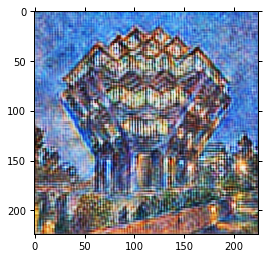

Epoch 1/10
1/1 [==============================] - 0s - loss: 76601.0078
Epoch 2/10
1/1 [==============================] - 0s - loss: 72127.7969
Epoch 3/10
1/1 [==============================] - 0s - loss: 68082.1953
Epoch 4/10
1/1 [==============================] - 0s - loss: 64515.1484
Epoch 5/10
1/1 [==============================] - 0s - loss: 61447.6328
Epoch 6/10
1/1 [==============================] - 0s - loss: 58864.5547
Epoch 7/10
1/1 [==============================] - 0s - loss: 56705.7461
Epoch 8/10
1/1 [==============================] - 0s - loss: 54884.8672
Epoch 9/10
1/1 [==============================] - 0s - loss: 53335.5312
Epoch 10/10
1/1 [==============================] - 0s - loss: 52024.6055
(3, 224, 224)


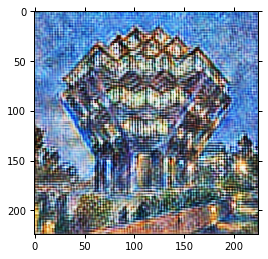

Epoch 1/10
1/1 [==============================] - 0s - loss: 50911.8906
Epoch 2/10
1/1 [==============================] - 0s - loss: 49958.8281
Epoch 3/10
1/1 [==============================] - 0s - loss: 49113.5547
Epoch 4/10
1/1 [==============================] - 0s - loss: 48344.9570
Epoch 5/10
1/1 [==============================] - 0s - loss: 47624.9492
Epoch 6/10
1/1 [==============================] - 0s - loss: 46936.0586
Epoch 7/10
1/1 [==============================] - 0s - loss: 46281.4688
Epoch 8/10
1/1 [==============================] - 0s - loss: 45648.0000
Epoch 9/10
1/1 [==============================] - 0s - loss: 45042.3086
Epoch 10/10
1/1 [==============================] - 0s - loss: 44470.1055
(3, 224, 224)


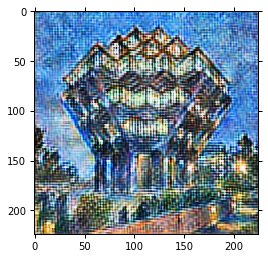

Epoch 1/10
1/1 [==============================] - 0s - loss: 43932.4492
Epoch 2/10
1/1 [==============================] - 0s - loss: 43427.2461
Epoch 3/10
1/1 [==============================] - 0s - loss: 42956.4141
Epoch 4/10
1/1 [==============================] - 0s - loss: 42515.6406
Epoch 5/10
1/1 [==============================] - 0s - loss: 42101.4961
Epoch 6/10
1/1 [==============================] - 0s - loss: 41716.4883
Epoch 7/10
1/1 [==============================] - 0s - loss: 41355.3867
Epoch 8/10
1/1 [==============================] - 0s - loss: 41014.3750
Epoch 9/10
1/1 [==============================] - 0s - loss: 40690.6133
Epoch 10/10
1/1 [==============================] - 0s - loss: 40382.7578
(3, 224, 224)


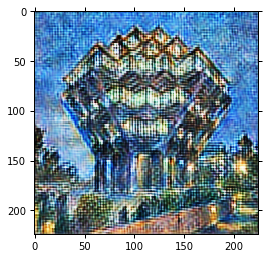

Epoch 1/10
1/1 [==============================] - 0s - loss: 40094.2773
Epoch 2/10
1/1 [==============================] - 0s - loss: 39821.8672
Epoch 3/10
1/1 [==============================] - 0s - loss: 39562.0938
Epoch 4/10
1/1 [==============================] - 0s - loss: 39311.2031
Epoch 5/10
1/1 [==============================] - 0s - loss: 39070.3047
Epoch 6/10
1/1 [==============================] - 0s - loss: 38840.4219
Epoch 7/10
1/1 [==============================] - 0s - loss: 38622.9844
Epoch 8/10
1/1 [==============================] - 0s - loss: 38416.0625
Epoch 9/10
1/1 [==============================] - 0s - loss: 38216.1250
Epoch 10/10
1/1 [==============================] - 0s - loss: 38023.6875
(3, 224, 224)


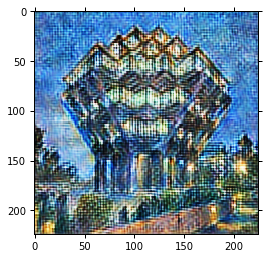

Epoch 1/10
1/1 [==============================] - 0s - loss: 37836.9023
Epoch 2/10
1/1 [==============================] - 0s - loss: 37656.5703
Epoch 3/10
1/1 [==============================] - 0s - loss: 37484.2227
Epoch 4/10
1/1 [==============================] - 0s - loss: 37319.1641
Epoch 5/10
1/1 [==============================] - 0s - loss: 37160.2969
Epoch 6/10
1/1 [==============================] - 0s - loss: 37007.1562
Epoch 7/10
1/1 [==============================] - 0s - loss: 36858.4609
Epoch 8/10
1/1 [==============================] - 0s - loss: 36714.4609
Epoch 9/10
1/1 [==============================] - 0s - loss: 36575.6797
Epoch 10/10
1/1 [==============================] - 0s - loss: 36441.0117
(3, 224, 224)


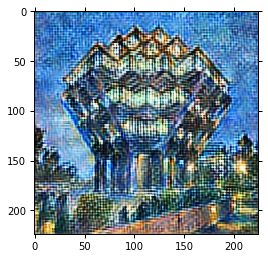

Epoch 1/10
1/1 [==============================] - 0s - loss: 36308.3633
Epoch 2/10
1/1 [==============================] - 0s - loss: 36179.8828
Epoch 3/10
1/1 [==============================] - 0s - loss: 36055.3984
Epoch 4/10
1/1 [==============================] - 0s - loss: 35935.2812
Epoch 5/10
1/1 [==============================] - 0s - loss: 35818.9609
Epoch 6/10
1/1 [==============================] - 0s - loss: 35704.9258
Epoch 7/10
1/1 [==============================] - 0s - loss: 35594.1562
Epoch 8/10
1/1 [==============================] - 0s - loss: 35486.4609
Epoch 9/10
1/1 [==============================] - 0s - loss: 35381.6055
Epoch 10/10
1/1 [==============================] - 0s - loss: 35279.5312
(3, 224, 224)


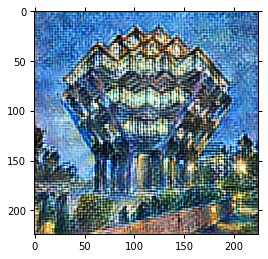

Epoch 1/10
1/1 [==============================] - 0s - loss: 35178.5156
Epoch 2/10
1/1 [==============================] - 0s - loss: 35080.7188
Epoch 3/10
1/1 [==============================] - 0s - loss: 34985.6953
Epoch 4/10
1/1 [==============================] - 0s - loss: 34892.5156
Epoch 5/10
1/1 [==============================] - 0s - loss: 34801.1172
Epoch 6/10
1/1 [==============================] - 0s - loss: 34711.8867
Epoch 7/10
1/1 [==============================] - 0s - loss: 34624.8359
Epoch 8/10
1/1 [==============================] - 0s - loss: 34540.5273
Epoch 9/10
1/1 [==============================] - 0s - loss: 34457.4883
Epoch 10/10
1/1 [==============================] - 0s - loss: 34375.6016
(3, 224, 224)


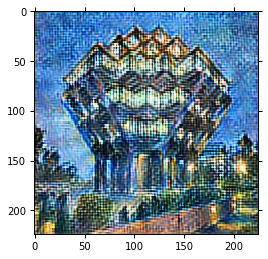

Epoch 1/10
1/1 [==============================] - 0s - loss: 34295.0703
Epoch 2/10
1/1 [==============================] - 0s - loss: 34216.5000
Epoch 3/10
1/1 [==============================] - 0s - loss: 34139.0703
Epoch 4/10
1/1 [==============================] - 0s - loss: 34062.5820
Epoch 5/10
1/1 [==============================] - 0s - loss: 33987.8008
Epoch 6/10
1/1 [==============================] - 0s - loss: 33913.5742
Epoch 7/10
1/1 [==============================] - 0s - loss: 33841.0117
Epoch 8/10
1/1 [==============================] - 0s - loss: 33770.0469
Epoch 9/10
1/1 [==============================] - 0s - loss: 33699.7109
Epoch 10/10
1/1 [==============================] - 0s - loss: 33630.9375
(3, 224, 224)


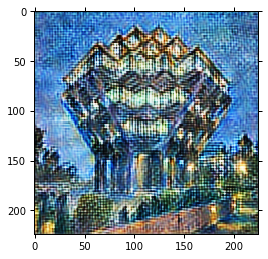

Epoch 1/10
1/1 [==============================] - 0s - loss: 33563.6602
Epoch 2/10
1/1 [==============================] - 0s - loss: 33497.2695
Epoch 3/10
1/1 [==============================] - 0s - loss: 33431.4258
Epoch 4/10
1/1 [==============================] - 0s - loss: 33365.9570
Epoch 5/10
1/1 [==============================] - 0s - loss: 33301.8320
Epoch 6/10
1/1 [==============================] - 0s - loss: 33238.0547
Epoch 7/10
1/1 [==============================] - 0s - loss: 33175.7031
Epoch 8/10
1/1 [==============================] - 0s - loss: 33113.9883
Epoch 9/10
1/1 [==============================] - 0s - loss: 33052.3555
Epoch 10/10
1/1 [==============================] - 0s - loss: 32991.1680
(3, 224, 224)


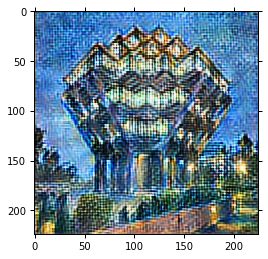

In [35]:
for i in range(10):
    generative_model.fit(trainX3, inpY, nb_epoch = 10)
    img = generative_model.predict(trainX3)
    img = img[0]
    print img.shape
    img = img.swapaxes(0, 2).swapaxes(0, 1)
    plt.imshow(img)
    plt.show()

In [40]:
jpgfile = Image.open("orig.jpg")
inp = np.array(jpgfile.getdata())
trainX = np.reshape(inp, (1, 3, 224, 224))
trainX2 = np.reshape(trainX, (1, np.product(trainX.shape)))
trainX3 = trainX2/256.0
print np.product(trainX.shape)
trainX3 = np.random.rand(1, 150528)

150528


(3, 224, 224)


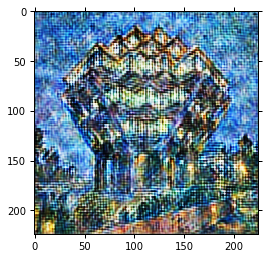

In [46]:
# generative_model.fit(trainX3, inpY, nb_epoch = 10)
img = generative_model.predict(trainX3)
img = img[0]
print img.shape
img = img.swapaxes(0, 2).swapaxes(0, 1)
plt.imshow(img)
plt.savefig('styletsfr.jpg')
# plt.show()